In [2]:
# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from IPython.display import display

# Machine Learning
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from fastai.imports import *

In [3]:
data = pd.read_csv('/Users/mengzhewang/Downloads/PUBG/aggregate/agg_match_stats_0.csv')

In [74]:
data.shape

(13849287, 22)

In [4]:
data.iloc[0,:]

date                                                           2017-11-26T20:59:40+0000
game_size                                                                            37
match_id               2U4GBNA0YmnNZYkzjkfgN4ev-hXSrak_BSey_YEG6kIuDG9fxFrrePqnqiM39pJO
match_mode                                                                          tpp
party_size                                                                            2
player_assists                                                                        0
player_dbno                                                                           1
player_dist_ride                                                               2870.724
player_dist_walk                                                             1784.84778
player_dmg                                                                          117
player_kills                                                                          1
player_name                     

Analysis of Data

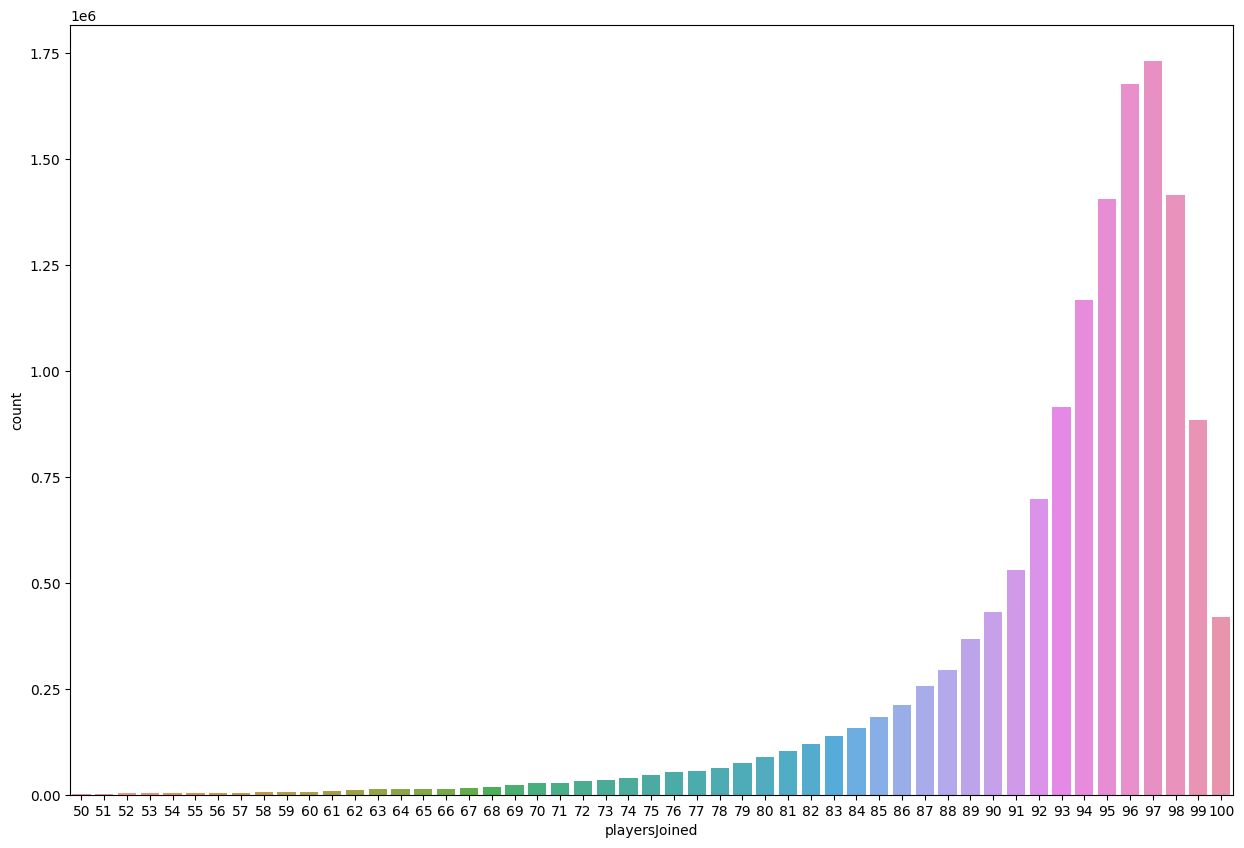

In [5]:
data['playersJoined'] = data.groupby('match_id')['match_id'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(x=data[data['playersJoined']>=50]['playersJoined']) 
plt.show()

In [6]:
# Create normalized features
data['killsNorm'] = data['player_kills']*((100-data['playersJoined'])/100 + 1)
data['damageDealtNorm'] = data['player_dmg']*((100-data['playersJoined'])/100 + 1)
data['assistsNorm'] = data['player_assists']*((100-data['playersJoined'])/100 + 1)
data['dbnoNorm'] = data['player_dbno']*((100-data['playersJoined'])/100 + 1)
data['surviveTimeNorm'] = data['player_survive_time']*(1 - (100-data['playersJoined'])/100)
# Compare standard features and normalized features
to_show = ['player_name', 'player_kills','killsNorm','player_dmg', 'damageDealtNorm', 'player_assists', 'assistsNorm', 'player_dbno', 'dbnoNorm', 'player_survive_time', 'surviveTimeNorm']
data[to_show][0:11]

,player_name,player_kills,killsNorm,player_dmg,damageDealtNorm,player_assists,assistsNorm,player_dbno,dbnoNorm,player_survive_time,surviveTimeNorm
0,SnuffIes,1,1.26,117,147.42,0,0.0,1,1.26,1106.320,818.67680
1,Ozon3r,1,1.26,127,160.02,0,0.0,1,1.26,1106.315,818.67310
2,bovize,0,0.00,67,84.42,0,0.0,0,0.00,235.558,174.31292
3,sbahn87,0,0.00,0,0.00,0,0.0,0,0.00,197.553,146.18922
4,GeminiZZZ,2,2.52,175,220.50,0,0.0,0,0.00,1537.495,1137.74630
5,AlexWho6,0,0.00,65,81.90,0,0.0,0,0.00,1537.500,1137.75000
6,R1dd1ck913,0,0.00,0,0.00,0,0.0,0,0.00,1264.792,935.94608
7,Emmylou89,0,0.00,0,0.00,0,0.0,0,0.00,1264.795,935.94830
8,ron-n,0,0.00,79,99.54,0,0.0,0,0.00,868.560,642.73440
9,SoSpicy,1,1.26,101,127.26,0,0.0,1,1.26,868.555,642.73070


In [7]:
# The target of prediction. This is a percentile winning placement, 
# where 1 corresponds to 1st place, and 0 corresponds to last place in the match.
data['winPlacePerc'] = data['team_placement']/data['game_size']

Drop data, match_id, player_name, team_id, match_mode and team_placement, because they probably won't be useful for our Machine Learning algorithm.

In [8]:
# Drop Id and date columns.
newdata = data.drop(columns = ['date','match_id', 'player_name', 'team_id', 'match_mode','team_placement'])

In [9]:
newdata.iloc[0,:]

game_size                37.000000
party_size                2.000000
player_assists            0.000000
player_dbno               1.000000
player_dist_ride       2870.724000
player_dist_walk       1784.847780
player_dmg              117.000000
player_kills              1.000000
player_survive_time    1106.320000
playersJoined            74.000000
killsNorm                 1.260000
damageDealtNorm         147.420000
assistsNorm               0.000000
dbnoNorm                  1.260000
surviveTimeNorm         818.676800
winPlacePerc              0.486486
Name: 0, dtype: float64

In [9]:
X = newdata.drop(columns = ['winPlacePerc'])
y = newdata['winPlacePerc']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

RF

We will take a sample of 500000 rows from our training set for easy debugging and exploration.

In [11]:
sample = 500000
X_train['y'] = y_train
df_sample = X_train.sample(sample)
X_train = X_train.drop(columns = ['y'])

In [12]:
# Split sample into training data and target variable
X_sample = df_sample.drop(columns = ['y']) #all columns except target
y_sample = df_sample['y'] # Only target variable

In [13]:
X_sample_train, X_sample_valid, y_sample_train, y_sample_valid = train_test_split(X_sample, y_sample, test_size=0.12, random_state=42)

In [50]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
def print_score(m : RandomForestRegressor, X_train, y_train, X_valid, y_valid):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

First basic Random Forest Model

In [51]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_sample_train, y_sample_train)
print_score(m1, X_sample_train, y_sample_train, X_sample_valid, y_sample_valid)

['mae train: ', 0.0628691430595802, 'mae val: ', 0.08818540615507411]


In [53]:
# What are the most predictive features according to our basic random forest model
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
fi = rf_feat_importance(m1, X_sample); fi[:10]

,cols,imp
8,player_survive_time,0.296156
14,surviveTimeNorm,0.276094
5,player_dist_walk,0.192216
4,player_dist_ride,0.092639
6,player_dmg,0.046407
11,damageDealtNorm,0.019704
0,game_size,0.015184
10,killsNorm,0.015018
7,player_kills,0.013700
9,playersJoined,0.010205


<Axes: ylabel='cols'>

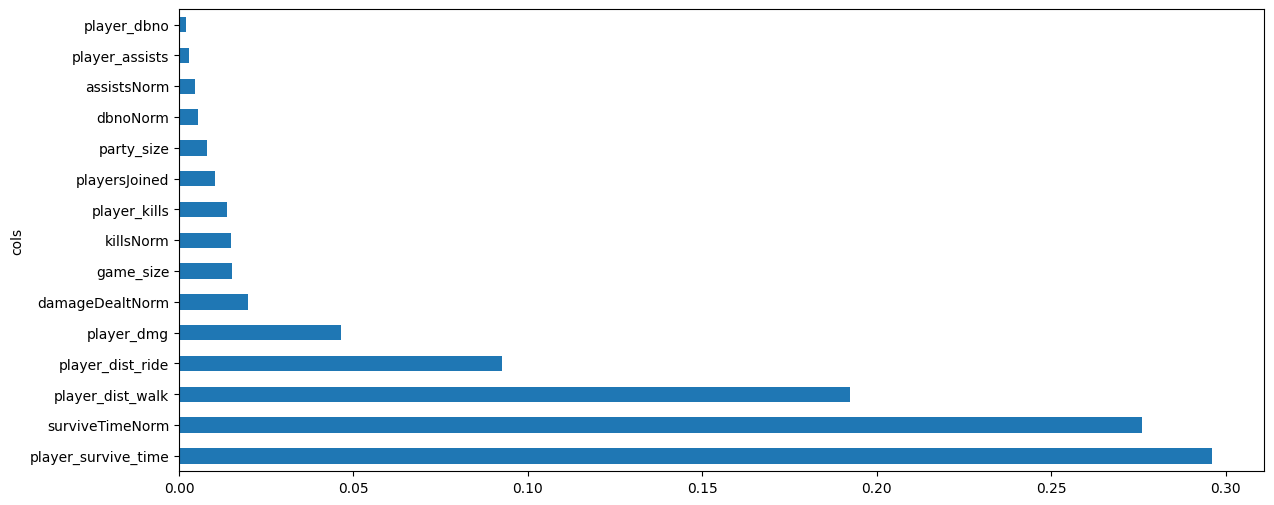

In [54]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [55]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  12


8     player_survive_time
14        surviveTimeNorm
5        player_dist_walk
4        player_dist_ride
6              player_dmg
11        damageDealtNorm
0               game_size
10              killsNorm
7            player_kills
9           playersJoined
1              party_size
13               dbnoNorm
Name: cols, dtype: object

In [56]:
# Make a DataFrame with only significant features
X_sample_train2 = X_sample_train[to_keep].copy()
X_sample_valid2 = X_sample_valid[to_keep].copy()

Second Random Forest Model

This time we use only the top features to train a random forest model. This often improves results a little bit.

In [39]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_sample_train2, y_sample_train)
print_score(m2, X_sample_train2, y_sample_train, X_sample_valid2, y_sample_valid)

['mae train: ', 0.06033618711736838, 'mae val: ', 0.08801584412186382]


<Axes: ylabel='cols'>

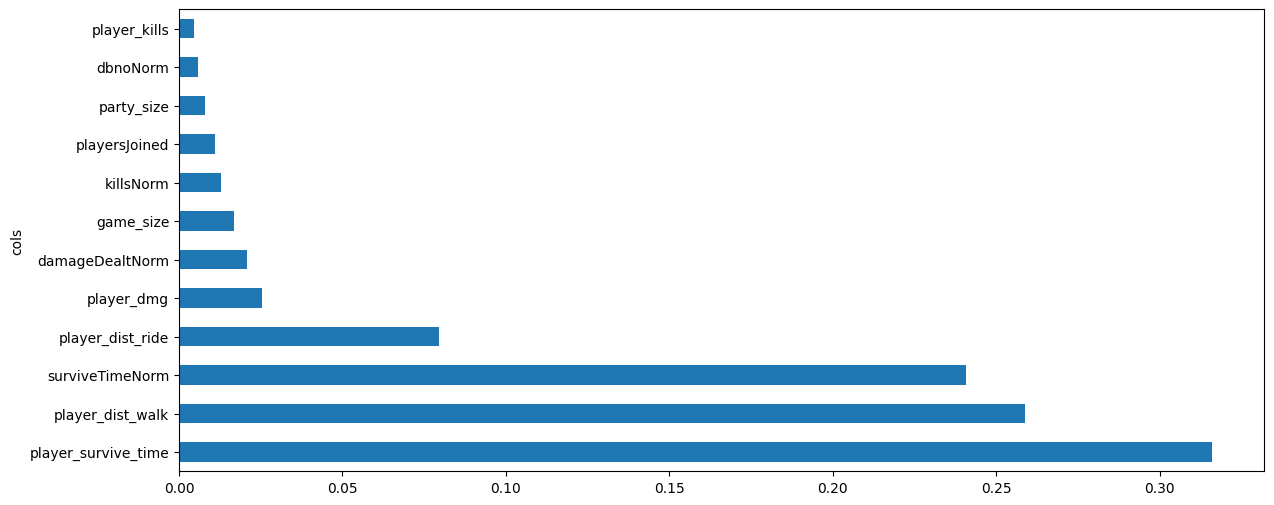

In [40]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, X_sample_train2)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

[]

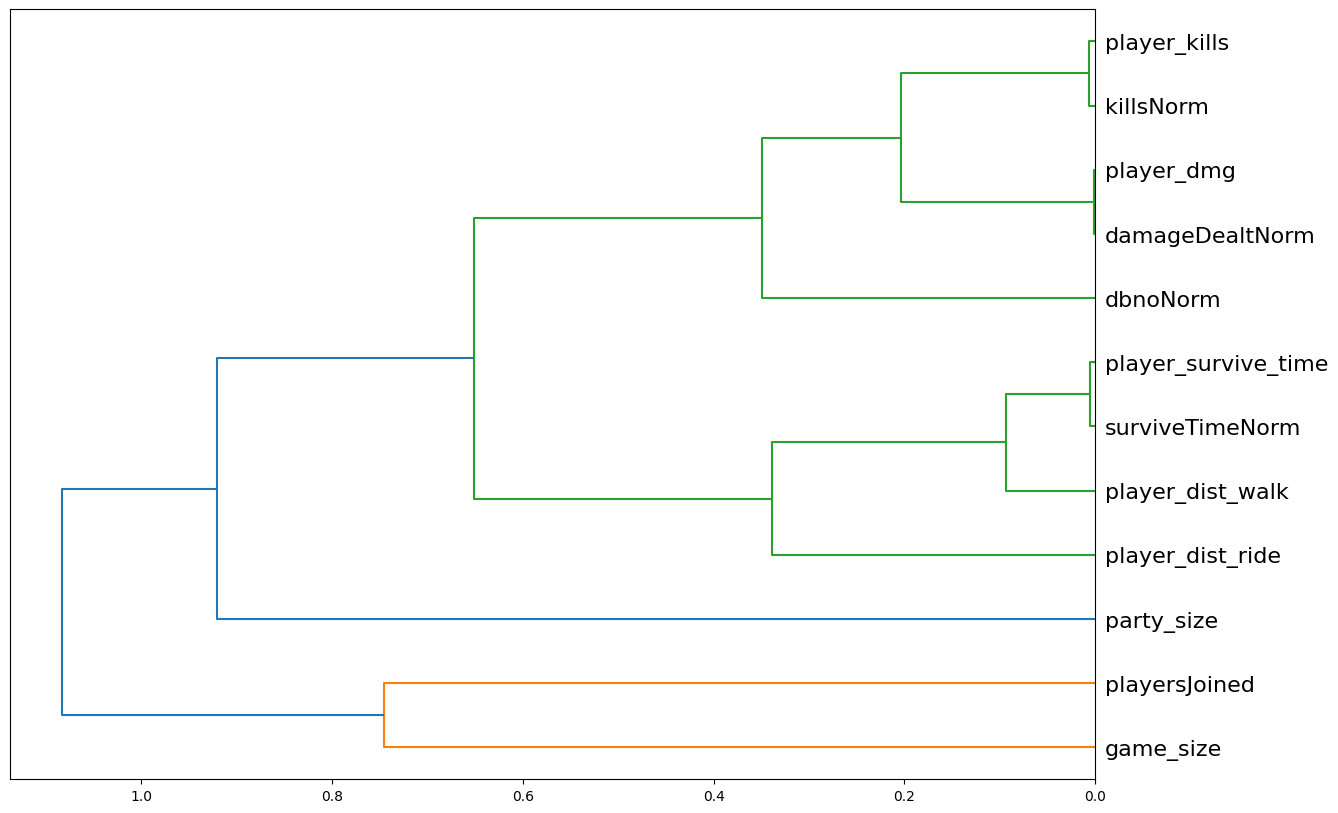

In [41]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(X_sample_train2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=X_sample_train2.columns, orientation='left', leaf_font_size=16)
plt.plot()

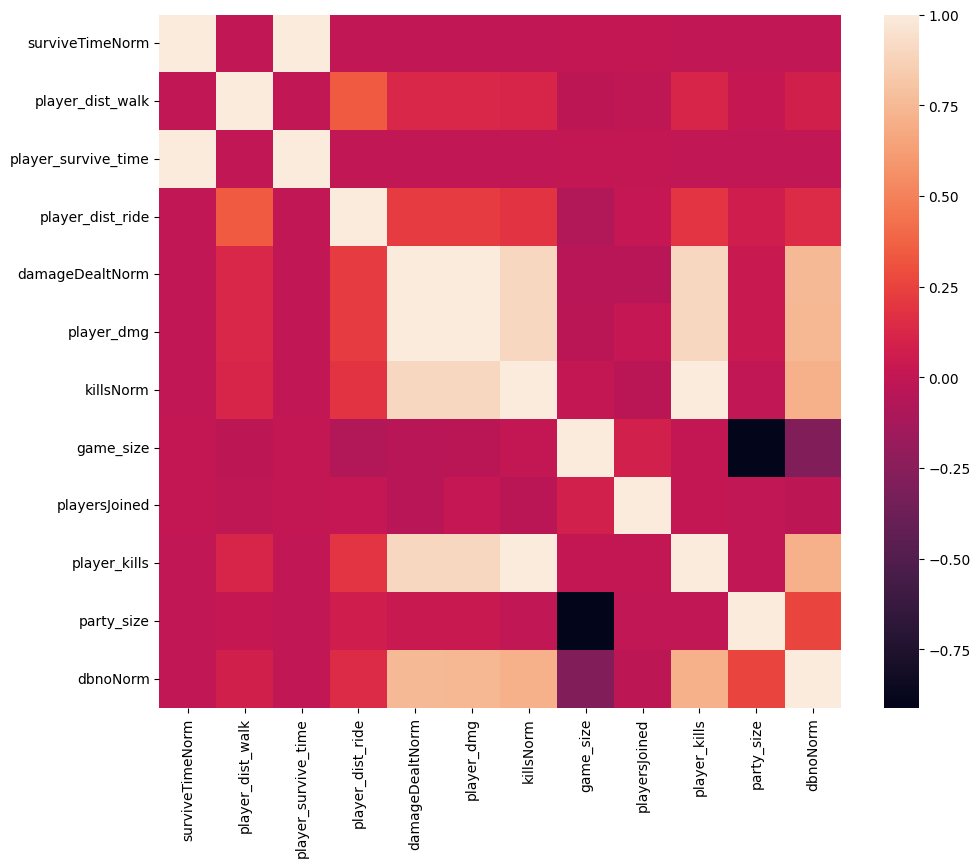

In [42]:
# Correlation heatmap
corr = X_sample_train2.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

Final Random Forest Model 

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

In [67]:
X_train2 = X_train[to_keep].copy()
X_valid2 = X_valid[to_keep].copy()

In [82]:
# Train final model
# You should get better results by increasing n_estimators
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m3.fit(X_train2, y_train)
print_score(m3, X_train2, y_train, X_valid2, y_valid)

['mae train: ', 0.05391830435253941, 'mae val: ', 0.08824599779270974]


In [63]:
X_test2 = X_test[to_keep].copy()

In [56]:
print('mae test: ', mean_absolute_error(m1.predict(X_test), y_test))

mae test:  0.08838968173128613


In [57]:
print('mae test: ', mean_absolute_error(m2.predict(X_test2), y_test))

mae test:  0.08830787458467966


In [58]:
print('mae test: ', mean_absolute_error(m3.predict(X_test2), y_test))

mae test:  0.08803711625041728


ANN

In [65]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

NN_model2 = Sequential()
# The Input Layer :
NN_model2.add(Dense(128, kernel_initializer='normal',input_dim = 12, activation='relu'))

# The Hidden Layers :
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model2.summary()
NN_model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               1664      
                                                                 
 dense_26 (Dense)            (None, 256)               33024     
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 166,529
Trainable params: 166,529
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
________________________

In [68]:
history2 = NN_model2.fit(X_train2,y_train,epochs=20,batch_size=32,validation_data=(X_valid2,y_valid))

Epoch 1/20
255174/255174 [==============================] - 364s 1ms/step - loss: 3.9715 - mean_absolute_error: 3.9715 - val_loss: 36.6791 - val_mean_absolute_error: 36.6791
Epoch 2/20
255174/255174 [==============================] - 364s 1ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.0853 - val_mean_absolute_error: 0.0853
Epoch 3/20
255174/255174 [==============================] - 363s 1ms/step - loss: 0.3423 - mean_absolute_error: 0.3423 - val_loss: 0.0853 - val_mean_absolute_error: 0.0853
Epoch 4/20
255174/255174 [==============================] - 353s 1ms/step - loss: 0.0850 - mean_absolute_error: 0.0850 - val_loss: 0.0849 - val_mean_absolute_error: 0.0849
Epoch 5/20
255174/255174 [==============================] - 354s 1ms/step - loss: 0.0850 - mean_absolute_error: 0.0850 - val_loss: 0.0847 - val_mean_absolute_error: 0.0847
Epoch 6/20
255174/255174 [==============================] - 354s 1ms/step - loss: 0.0850 - mean_absolute_error: 0.0850 - val_loss: 0.0851 

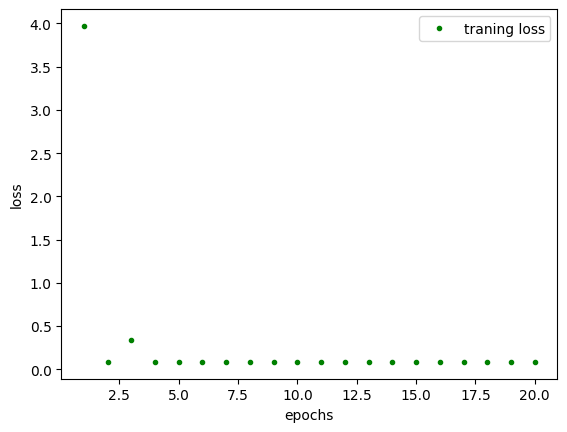

In [75]:
loss=history2.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'g.',label='traning loss')
#plt.plot(epochs,val_loss,'b.',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

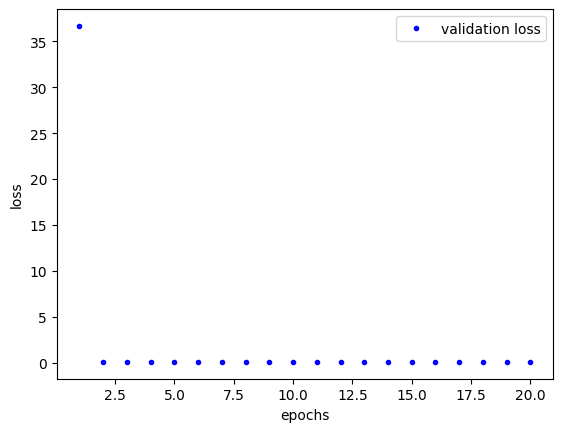

In [80]:
loss=history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(loss)+1)
#plt.plot(epochs,loss,'g.',label='traning loss')
plt.plot(epochs,val_loss,'b.',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_absolute_error
print('mae test: ', mean_absolute_error(y_test, NN_model2.predict(X_test2)))

142821/142821 [==============================] - 71s 496us/step
mae test:  0.08609951355622797


LinearRegression

In [72]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train2, y_train)
print_score(reg,X_train2, y_train, X_valid2, y_valid)

['mae train: ', 0.190152660002455, 'mae val: ', 0.1902977612680236]


In [73]:
print('mae test: ', mean_absolute_error(y_test, reg.predict(X_test2)))

mae test:  0.19024784903827774
